# 《机器学习》从零开始学(31) 概率图模型专题之精确推断：变量消除

参考教材：

    1）机器学习-周志华-清华大学出版社-2016  链接:https://pan.baidu.com/s/1c1DSE2W 密码:gufi
    2）概率图模型：原理与技术-[美]D·科勒＆[以色列]N·弗里德曼-王飞跃＆韩素青(译)-清华大学出版社-2015  链接:https://pan.baidu.com/s/1dEBk2rf 密码:77hq

所谓“从零开始”面向的对象其实仅指我本人。也就是我的学习笔记。

**注意**：

1. 此笔记是在我理解基础上的梳理和表述。 

2. 本笔记的代码无法在聚宽上运行，请复制到本地运行(Python2.7，并安装[pgmpy](https://github.com/pgmpy)及其依赖库)。

3. 由于概率图模型有不少难点，所以本笔记不追求自己实现算法，而利用一个冷门库**[pgmpy](http://pgmpy.org/)**作为演练工具（我暂时没有找到更适合的），而具体算法部分可能会从其源代码中截取一段代码做示例。

4. 我隐隐感觉，在**tensorflow**框架下也应该可以实现概率图模型，这方面留到以后研究吧。

本节重点在 概率图模型的精确推断：**变量消除算法**。

## 1）推断的复杂性

表面上看，一旦获得概率图网络的联合分布，对于概率或条件概率的，无非就是反复利用**边缘求和**与**贝叶斯定理**及其推论**概率链式法则**。 

对于非常简单的网络，的确非常简单，手工精确推断也毫无障碍。 但面对稍微复杂些的网络，立刻就会出现**指数爆炸**的现象。

甚至，业已证明，**精确推断**是一个NP难题。 更糟糕的是， **近似推断**也是一个NP难题。

但好消息是： 在**最坏的情况**下才是NP难题。而现实中，对于少量的、离散的随机变量，还是可以使用**精确推断**的。  当然现实中比较大网络，我们也还是可以、并不得不使用**近似推断**。

## 2）变量消除算法

原则上，概率或条件概率的**查询**就是基于**联合概率分布**中无关变量的消除。比如：

假设$P(\boldsymbol{x}) = P(\boldsymbol{x}_q,\boldsymbol{x}_n, \boldsymbol{x}_v)$构成完整的联合概率分布，$\boldsymbol{x}_n$是我们不关心的变量集。

对**先验概率分布**（可能是联合分布）的查询:

$$
P(\boldsymbol{x}_q) = \sum_{\boldsymbol{x}_n} P(\boldsymbol{x}_q,\boldsymbol{x}_n)
$$

通过对$\boldsymbol{x}_n$进行边缘求和（求积分）的方式消除这个无关变量.

对**条件概率分布**（可能是联合分布）的查询:

$$
P(\boldsymbol{x}_q\ |\ \boldsymbol{x}_v) = \sum_{\boldsymbol{x}_n} P(\boldsymbol{x}_q,\boldsymbol{x}_n\ |\ \boldsymbol{x}_v) = \dfrac{\sum_{\boldsymbol{x}_n} P(\boldsymbol{x}_q,\boldsymbol{x}_n, \boldsymbol{x}_v)}{\sum_{\boldsymbol{x}_q,\ \boldsymbol{x}_n} P(\boldsymbol{x}_q,\boldsymbol{x}_n, \boldsymbol{x}_v)}
$$


分子部分也是消除无关变量$\boldsymbol{x}_n$。分母部分则是通过边缘求和（求积分）的方式消除$\boldsymbol{x}_v$以外的变量。分子除于分母可以看成归一化。

我们先考虑一个简单的链式贝叶斯网。

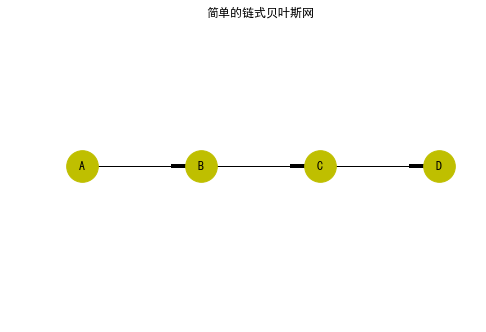

In [9]:
import requests
import networkx as nx

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

import matplotlib.pyplot as plt
%matplotlib inline

def buildBayesianModel(url, show=True):
    '''
            构建有限个离散随机变量的贝叶斯网络
    
    参数：
        url：  已经配置好参数的json文件的网址
        show:  模拟绘制有向图
    '''
    
    r = requests.get(url)
    r.encoding = "GBK"
    param = r.json()

    # 建立贝叶斯网骨架
    model = BayesianModel(param["E"])

    # 添加离散的、概率或条件概率分布表 
    vdata = param["Vdata"]
    for v in vdata:
        cpd = TabularCPD(variable=v, 
                         variable_card=vdata[v]["variable_card"],      
                         values=vdata[v]["values"],
                         evidence=vdata[v]["evidence"],
                         evidence_card=vdata[v]["evidence_card"])
        model.add_cpds(cpd)

    # 验证模型数据的一致性
    if not model.check_model():
        return None
        
    if show:
        # 绘制贝叶斯网的结构
        nx.draw(model, with_labels=True, node_size=1000, font_weight='bold', node_color='y', pos= param["V"])
        plt.title(param["T"])
        plt.show()
    
    return model

# 建立一个简单的链式贝叶斯网
model = buildBayesianModel("https://jiage.la/upload/201709615202681300993.txt")

对这个简单情况而言，根据变量消除的边缘求和，我们容易想到矩阵乘法（其定义本质上也是边缘求和），于是很容易直接由矩阵乘法算出各节点的先验概率：

分别是： 

$
\begin{array}
&P(A)\\
P(B)=\sum_A P(A) P(B\ |\ A)\\
P(C)= \sum_B \left\{\sum_A P(A) P(B\ |\ A)\right\} P(C\ |\ B)\\
P(D)=\sum_C \left\{\sum_B \left\{\sum_A P(A) P(B\ |\ A)\right\} P(C\ |\ B)\right\} P(C\ |\ D)
\end{array}
$

由此看出，变量消除的另一个因素就是**变量消除的次序**。这个简单情况下消除次序就是： $A,B,C$。

In [2]:
print "P(A) = ",model.get_cpds('A').values
print "P(B) = ",model.get_cpds('A').values.dot(model.get_cpds('B').values.T)
print "P(C) = ",model.get_cpds('A').values.dot(model.get_cpds('B').values.T) \
                    .dot(model.get_cpds('C').values.T)
print "P(D) = ",model.get_cpds('A').values.dot(model.get_cpds('B').values.T) \
                    .dot(model.get_cpds('C').values.T).dot(model.get_cpds('D').values.T)

P(A) =  [ 0.6  0.4]
P(B) =  [ 0.2   0.34  0.46]
P(C) =  [ 0.6114  0.3886]
P(D) =  [ 0.65855  0.34145]


实际上，我们用pgmpy库也能算出相同的结果：

In [3]:
import numpy as np
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

q = infer.query(variables=['A'], evidence={})
print q['A']

q = infer.query(variables=['B'], evidence={})
print q['B']

q = infer.query(variables=['C'], evidence={})
print q['C']

q = infer.query(variables=['D'], evidence={})
print q['D']

+-----+----------+
| A   |   phi(A) |
|-----+----------|
| A_0 |   0.6000 |
| A_1 |   0.4000 |
+-----+----------+
+-----+----------+
| B   |   phi(B) |
|-----+----------|
| B_0 |   0.2000 |
| B_1 |   0.3400 |
| B_2 |   0.4600 |
+-----+----------+
+-----+----------+
| C   |   phi(C) |
|-----+----------|
| C_0 |   0.6114 |
| C_1 |   0.3886 |
+-----+----------+
+-----+----------+
| D   |   phi(D) |
|-----+----------|
| D_0 |   0.6585 |
| D_1 |   0.3414 |
+-----+----------+


再看一个更复杂的一个贝叶斯网：

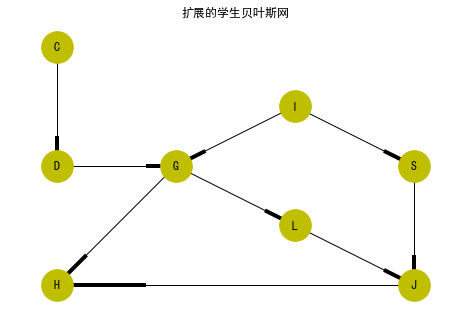

In [4]:
# 建立扩展的学生贝叶斯网
model = buildBayesianModel("https://jiage.la/upload/201709618010595351319.txt")

事实上（根据笔记的29和30节），无论是**贝叶斯网**还是**马尔可夫网**，其联合概率分布都可以写成因子乘积。 上面这个贝叶斯网的联合概率分布可以写成：

$$
\begin{array}
& \quad &\quad & P(C,D,I,G,S,L,H,J)\\
\quad &=& P(C)\ P(D\ |\ C)\ P(I)\ P(G\ |\ D,I)\ P(S\ |\ I)\ P(L\ |\ G)\ P(H\ |\ G,J)\ P(J\ |\ L,S) \\
\quad &\overset{\Delta}{=}& \phi_C(C)\ \phi_D(D,C)\ \phi_I(I)\ \phi_G(G,D,I)\ \phi_S(S,I)\ \phi_L(L,G)\ \phi_H(H,G,J)\ \phi_J(J,L,S)
\end{array}
$$

进而，对一般的贝叶斯网的**联合概率分布**也可以写成类似**马尔科夫网**的类似的因子分解形式：

$$
P(\boldsymbol{x})=\prod_{\phi \in \Phi} \phi
$$

其中，$\Phi$是所有因子的集合, $\mathrm{Scope}[\phi]$代表因子$\phi$的**辖域**。

$\Phi=\{\phi_C, \dots, \phi_J\}, \quad \mathrm{Scope}[\phi_C]=\{C \},\dots,\mathrm{Scope}[\psi_J]=\{J,L,S \}$。

如果给定了变量消除次序$Z$，那么**变量消除算法**就是**和-积变量消除**(VE)：

$$
\sum_Z \prod_{\phi \in \Phi} \phi
$$

经过前面的学习，我们发现**变量消除算法**本质上很简单，但需要预先给出消除次序。  下面总结如下：

![条件概率的证据处理](https://jiage.la/upload/201709711534445624711.png)

![变量消除算法](https://jiage.la/upload/201709711491086280758.png)

下面的代码，以扩展的学生贝叶斯网，展示了变量消除算法的全过程：

In [5]:
# 代码改自： http://pgmpy.org/_modules/pgmpy/inference/ExactInference.html#VariableElimination.query

from pgmpy.inference import VariableElimination

# 目标计算： P( H,J | G)
variables = ["H","J"]
evidence = {"G":0}

# 利用pgmpy精确推断类（VariableElimination）已实现的元功能，来展示 变量消除算法 。
infer = VariableElimination(model)

# 已消除的变量
eliminated_variables = set()

# 尚未处理的、各变量所涉及的因子集
working_factors = {node: {factor for factor in infer.factors[node]} for node in infer.factors}

'''
    证据处理
'''

if evidence:
    for evidence_var in evidence:
        for factor in working_factors[evidence_var]:
            # 对于给定值进行变量缩减
            factor_reduced = factor.reduce([(evidence_var, evidence[evidence_var])], inplace=False)
            # 更新尚未处理的因子集
            for var in factor_reduced.scope():
                working_factors[var].remove(factor)
                working_factors[var].add(factor_reduced)
        # 删除已消失变量对应的因子集
        del working_factors[evidence_var]

'''
    随便选择的一个消除次序
'''

elimination_order = list(set(infer.variables) - set(variables) - set(evidence.keys() if evidence else []))

# 待消除变量涉及的、并且其辖域不包括已消除变量的因子列表
factors = [factor for factor in working_factors[var]
           if not set(factor.variables).intersection(eliminated_variables)]

for var in elimination_order:
    # 待消除变量涉及的、并且其辖域不包括已消除变量的因子列表
    factors = [factor for factor in working_factors[var]
               if not set(factor.variables).intersection(eliminated_variables)]
    # 因子乘积
    phi = None
    for fact in factors:
        if phi is None:
            phi = fact
        else:
            phi.product(fact)
    # 对当前待消除变量进行边缘求和
    phi =  phi.marginalize([var], inplace=False)
    # 删除已经消除变量所对应的因子集
    del working_factors[var]
    # 由于有新的因子产生（替代了已经删除因子），所以要更新
    for variable in phi.variables:
        working_factors[variable].add(phi)
    # 记录已消除的变量
    eliminated_variables.add(var)

# 将所有不存在已消除变量的因子，合并到一个集合中（自然确保无重复）
final_distribution = set()
for node in working_factors:
    factors = working_factors[node]
    for factor in factors:
        if not set(factor.variables).intersection(eliminated_variables):
            final_distribution.add(factor)


# 最后进行因子乘积：生成查询变量的“联合概率分布”（一般而言，不要求归一化）
phi = None
for fact in final_distribution:
    if phi is None:
        phi = fact
    else:
        phi.product(fact)

# 各查询变量： 对其它变量边缘求和，然后标准化
query_var_factor = {}
for query_var in variables:    
    query_var_factor[query_var] = phi.marginalize(
            list(set(variables) - set([query_var])),
            inplace=False
        ).normalize(inplace=False)

print "【下面的概率，可能是条件概率，取决于前面是否提供证据】\n"
print "所有查询变量的联合概率分布：\n",phi
print "\n各目标查询变量的概率分布：\n"
print query_var_factor['H']
print query_var_factor['J']

【下面的概率，可能是条件概率，取决于前面是否提供证据】

所有查询变量的联合概率分布：
+-----+-----+------------+
| H   | J   |   phi(H,J) |
|-----+-----+------------|
| H_0 | J_0 |     0.0096 |
| H_0 | J_1 |     0.1018 |
| H_1 | J_0 |     0.0861 |
| H_1 | J_1 |     0.1527 |
+-----+-----+------------+

各目标查询变量的概率分布：

+-----+----------+
| H   |   phi(H) |
|-----+----------|
| H_0 |   0.3180 |
| H_1 |   0.6820 |
+-----+----------+
+-----+----------+
| J   |   phi(J) |
|-----+----------|
| J_0 |   0.2732 |
| J_1 |   0.7268 |
+-----+----------+


事实上，前面这段代码就源自下面代码的源码实现：

In [6]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

q = infer.query(variables=['H','J'], evidence={'G':0})
print q['H']
print q['J']

+-----+----------+
| H   |   phi(H) |
|-----+----------|
| H_0 |   0.3180 |
| H_1 |   0.6820 |
+-----+----------+
+-----+----------+
| J   |   phi(J) |
|-----+----------|
| J_0 |   0.2732 |
| J_1 |   0.7268 |
+-----+----------+


## 3) 变量消除次序与图论分析

前面的算法，是需要先给定变量消除次序的。 当然，我们还是希望能够自动产生出一个**变量消除次序**,使得计算代价最低。

为此，书中基于给定的**变量消除次序**，引入了一个**导出图**的概念。 **导出图**是一个无向图，按指定次序消除变量的过程中，会产生一系列中间因子， 如果两个变量同时出现在某个中间因子的辖域中，那么这两个变量由一条边连接。  而 **导出图**的**最大团**（节点数最多的**极大团**）的节点个数减1，就是**导出图**的宽度

比如：

消除次序: [u'C', u'D', u'G', u'I', u'H', u'J', u'L', u'S']
对应的导出图宽度： 4


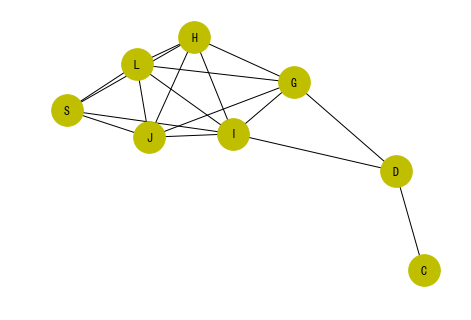

In [7]:
infer = VariableElimination(model)

print "消除次序:",infer.variables
print "对应的导出图宽度：",infer.induced_width(infer.variables)
nx.draw(infer.induced_graph(infer.variables), with_labels=True, node_size=1000, font_weight='bold', node_color='y')
plt.show()

书中证明了： 最小的导出图宽度，对应着计算量最小的变量消除次序。 

但问题是，寻找最小的导出图宽度的消除次序，最坏的情况下，是一个NP难题。

尽管如此，是有些技巧，通过贪心算法获得较好的消除次序：

比如： 最近邻居数越少排的越前：  pgmpy.inference.EliminationOrder.MinNeighbours

消除次序: [u'C', u'H', u'D', u'I', u'S', u'L', u'J', u'G']
对应的导出图宽度： 3


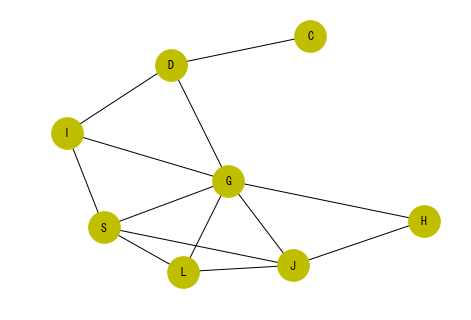

In [8]:
from pgmpy.inference.EliminationOrder import MinNeighbours  #, WeightedMinFill, MinWeight, MinFill
# 最近邻居数越少排的越前
variables = MinNeighbours(model).get_elimination_order(infer.variables)
infer = VariableElimination(model)
print "消除次序:",variables
print "对应的导出图宽度：",infer.induced_width(variables)
nx.draw(infer.induced_graph(variables), with_labels=True, node_size=1000, font_weight='bold', node_color='y')
plt.show()